## Imports

In [1]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [2]:
download_assets(VideoAssets.VEHICLES)

vehicles.mp4 asset download complete. 



'vehicles.mp4'

## Configuration

In [3]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

## Source and Target ROIs

![Source and Target ROIs](https://storage.googleapis.com/com-roboflow-marketing/notebooks/speed-estimation-perspective-1.png)

### Perspective-to-BEV Transformation Overview

To estimate vehicle speed accurately, the system converts the camera’s perspective view into a bird’s-eye metric view using a 4-point homography.

In the SOURCE image, a quadrilateral (A, B, C, D) is manually defined around the drivable road surface. Due to camera perspective, this shape is trapezoidal and cannot be used directly for distance measurements.

Using homography, this quadrilateral is mapped to a rectangular TARGET space (A′, B′, C′, D′) whose dimensions are chosen to represent real-world distances (e.g., 25m × 250m). This BEV space ensures that each pixel corresponds to a fixed physical distance, and vehicle motion is linear along the vertical axis.

Once vehicles are detected and tracked, their anchor points are transformed into BEV coordinates. Speed is then calculated by measuring the displacement of these BEV points over time, yielding accurate km/h values independent of camera perspective.

1.	SOURCE contains four points on the road in the original camera image — the trapezoid that covers the drivable area.
2.	These points are in pixel coordinates (x, y) and outline the road as seen with perspective (wide at bottom, narrow at top).
3.	TARGET contains four points of a clean vertical rectangle, representing a bird’s-eye-view (BEV) of the same road.
4.	A homography transform maps the SOURCE trapezoid → TARGET rectangle, removing perspective distortion.
5.	This BEV mapping allows straight-line motion, constant scale, and accurate speed measurement in meters per pixel.

**SOURCE quadrilateral:**
```
(1252,787) ---- (2298,803)
      \             /
       \           /
 (-550,2159) -- (5039,2159)
 ```
 ***Mapped onto: TARGET rectangle:***
 ```
 (0,0) ---- (24,0)
  |          |
  |          |
(0,249)-- (24,249)
```

In [4]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

### ***What this does:***
1.	sv.get_video_frames_generator(...)\
Creates a generator that yields frames one by one from SOURCE_VIDEO_PATH (your input video).

2.	frame = next(frame_iterator)\
Grabs the first frame from the video for visualization.

In [5]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

3.	annotated_frame = frame.copy()\
Makes a copy so we can draw on it without modifying the original frame.
4.	sv.draw_polygon(..., polygon=SOURCE, ...)\
Draws the SOURCE quadrilateral (your road ROI) as a red outline with thickness 4 pixels on top of the frame.
5.	sv.plot_image(annotated_frame)\
Displays the annotated frame in the notebook so you can visually verify that the polygon correctly covers the road region.

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


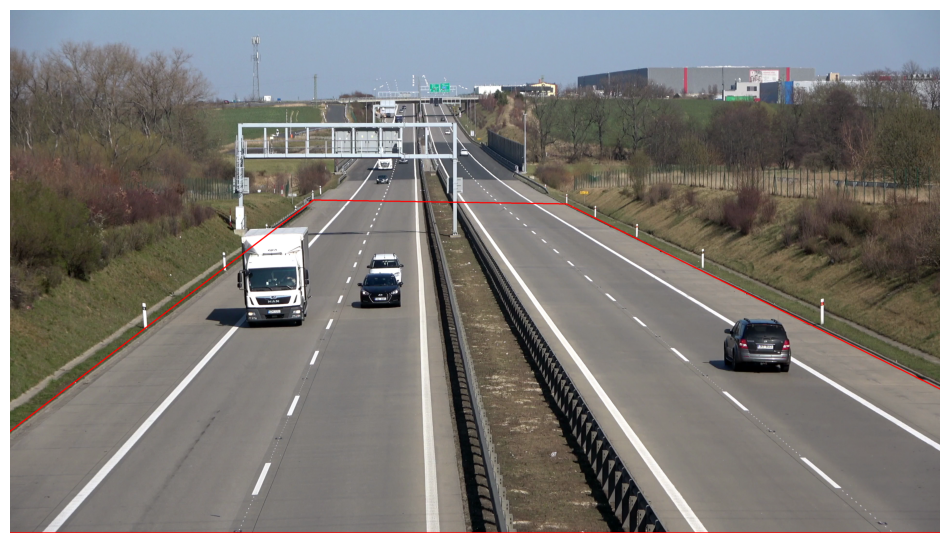

In [6]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

## 📐 ViewTransformer: Perspective Warp for Speed Estimation

This class converts points from the original camera view into a top-down (birds-eye) view using a perspective transform.
This is essential because distance measured in the camera image is distorted, but the BEV view gives uniform, real-world-like distance for accurate speed calculation.

### 📐 What the 3×3 matrix actually does

cv2.getPerspectiveTransform(source, target) computes a matrix that:

1. Finds the exact mathematical relationship between

✔ the 4 points in the CAMERA image (SOURCE polygon)
✔ the 4 points in the BEV rectangle (TARGET polygon)

2. Computes how each pixel in SOURCE should be stretched/squished in TARGET

It performs:
	•	stretching
	•	shearing
	•	warping
	•	projective correction

To “flatten” the camera projection into a top-down view.

3. Allows converting ANY (x, y) position from camera view → BEV view

###  OpenCV

- OpenCV (Open Computer Vision) is a very popular library used for:
	-	image processing
- We are using it here ONLY for perspective transformation — the part that lets us convert camera coordinates into top-down (BEV) coordinates.

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        # 4 points defining a quadrilateral in the camera image.
        source = source.astype(np.float32)
        # 4 points representing a flat rectangle in BEV space.
        target = target.astype(np.float32)
        # Computes a 3×3 matrix that maps every point in source → target.
        # This matrix will “unskew” the highway surface into a vertical strip.
        # Here we are creating this transform matrix
        self.m = cv2.getPerspectiveTransform(source, target)



    # What this does:
	# 1. Reshapes your (x, y) points into the format OpenCV needs (N, 1, 2)
	# 2. Applies perspective transform using matrix self.m
	# 3. Returns the transformed coordinates in BEV space
    # This is what lets you measure pixel distance → meters → km/h.
    def transform_points(self, points: np.ndarray) -> np.ndarray:
        #  If no points → return immediately
        if points.size == 0:
            return points
        # Because OpenCV requires a specific shape for perspective transformation: (N, 1, 2)
        	# •	N → number of points
            # •	1 → dummy dimension
            # •	2 → (x, y)
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        # Applying transform matrix 
        # Computes the 3×3 matrix based on the 4 SOURCE → 4 TARGET point pairs.
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [8]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Object Detection, Tracking, and Speed Estimation Pipeline

***This block runs the full per-frame pipeline: YOLO detection → filtering → tracking → speed estimation → annotation → video export.***

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

This block takes each video frame, detects and tracks vehicles with YOLO + ByteTrack, filters them to a road polygon, transforms their positions into BEV space to estimate speed, overlays ID / type / speed labels, and writes the result into an annotated output video.

In [ ]:
# loads the pre-trained YOLO model used to detect vehicles in each frame.
model = YOLO(MODEL_NAME)

# reads FPS, resolution, and total frame count from the input video.
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
#  creates a generator that yields one frame at a time from the source video.
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
# ByteTrack: multi-object tracker that assigns a persistent ID to each vehicle across frames (e.g. #3, #7).
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_dynamic_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # 1. Run YOLO and convert to Supervision detections
        #     •	Runs YOLO on the current frame.
        #     •	Wraps output into a Detections object.
        #     •	names maps class_id → class_name (e.g. 2 → "car").
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        names = result.names  # dict: class_id -> "car", "truck", etc.

        # 2. Filter detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD] # Remove low-confidence detections.
        detections = detections[detections.class_id != 0] # Remove class 0 (usually “person”), keeping vehicles only.
        detections = detections[polygon_zone.trigger(detections)] # filter out detections outside the zone
        detections = detections.with_nms(IOU_THRESHOLD) # refine detections using non-max suppression

        # 3. Track objects across frames: pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        # 4. Get anchor points and transform to BEV
        #   • Uses the bottom-center of each bounding box as the vehicle’s reference point on the road.
        #   • Applies the perspective transform (BEV) so movement is measured in a flattened, metric-like space.
        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER 
        )
        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # 5. Update per-vehicle coordinate history
            # •	For each tracked vehicle, stores its recent Y position in BEV coordinates.
	        # •	This history is used to compute speed from distance/time.
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # 6. Build labels with ID, class name, and speed
        #     •	If there is not enough history yet → show only #ID + class (e.g. #3 car).
        #     •	If enough history → compute speed from BEV displacement:
        #       •	distance = difference in BEV Y positions
        #       •	time = number of frames / FPS
        #       •	speed = (distance / time) × 3.6 → km/h
        #     •	Final label looks like: #3 car 48 km/h.       
        labels = [] # format labels (ID + class name + speed)

        # zip class_id and tracker_id so we can use both
        for class_id, tracker_id in zip(detections.class_id, detections.tracker_id):
            class_name = names[int(class_id)]  # e.g. "car", "truck", "bus"

            if len(coordinates[tracker_id]) < video_info.fps / 2:
                # not enough history yet → just show ID + type
                labels.append(f"#{tracker_id} {class_name}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6

                labels.append(f"#{tracker_id} {class_name} {int(speed)} km/h")

        # annotate frame
        	# •	Draws the motion trace, bounding boxes, and text labels on the frame.
	        # •	Writes the annotated frame to the output video via VideoSink.
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
100%|██████████| 538/538 [04:23<00:00,  2.04it/s]
